# 用于生成论文中的一些图片

In [117]:
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
import random
import matplotlib.pyplot as plt
from CPP_Planner import CPP_Planner_Kit
from shapely import Point, LineString
from enum import Enum
from rasterio.mask import mask

In [118]:
# hard-code 各个列表
swath_sep_indxes = [0, 28, 39, 49, 71]
useful_land_indexes = [0, 4, 5, 6]
# 一些农机数据
vehicle_weight = 1980 + 342.5  # 拖拉机 + 耕作机械 重量（kg）
vehicle_wheel_width = 1440  # 农机轮距（mm）

opti_path = '../PSO_opt_result/opt12/pso_result.csv'
# real_swath_path = '../Scratch/test_Load_Shp/test_shps/swath_group_1.shp'
# straight_swath_path = 'GIS_data/straight_swaths/straight_swaths.shp'
real_swath_path = r'GIS_data/路径规划优化用数据/all_swaths/all_swaths_group.shp'
straight_swath_path = r'GIS_data/路径规划优化用数据/all_swaths/all_straight_swaths_group.shp'
opti_parameters = pd.read_csv(opti_path)
real_swath = gpd.read_file(real_swath_path)
straight_swath = gpd.read_file(straight_swath_path)
# all_land = gpd.read_file('../Scratch/test_Load_Shp/shp_file/村地和道路/村地地块区域.shp')
all_land = gpd.read_file('GIS_data/路径规划优化用数据/seperate_land_0.shp')
print(opti_parameters.shape)
print('straight and real swaths: ', len(straight_swath), end=' ')
print(len(real_swath))

dem_src = rasterio.open('GIS_data/路径规划优化用数据/2m_pClouds_regen_dem_cm.tif')
aspect_src = rasterio.open('GIS_data/路径规划优化用数据/Aspect_clip_pcGen_2m_cm1.tif')
slope_src = rasterio.open('GIS_data/路径规划优化用数据/Slope_clip_pcGen_2m_cm1.tif')
curvature_src = rasterio.open('GIS_data/路径规划优化用数据/Curvatu_clip_pcGen_2m_cm1.tif')

dem_array = dem_src.read(1)
aspect_array = aspect_src.read(1)
slope_array = slope_src.read(1)
curvature_array = curvature_src.read(1)

(100, 6)
straight and real swaths:  71 71


<AxesSubplot: title={'center': 'all_land'}>

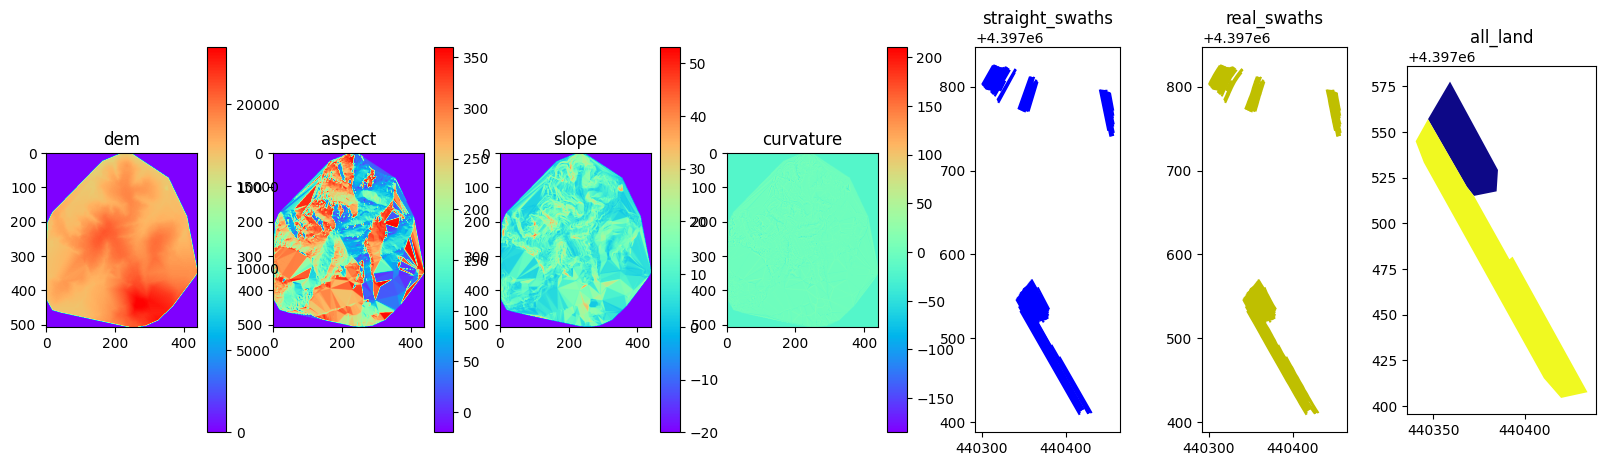

In [119]:
# 预处理，设置NODATA为特殊的值
NODATA = -20
dem_array[dem_array == dem_array.min()] = NODATA
aspect_array[aspect_array == aspect_array.min()] = NODATA
slope_array[slope_array == slope_array.min()] = NODATA
curvature_array[curvature_array == curvature_array.min()] = NODATA

# show
_, axes = plt.subplots(ncols=7, nrows=1, dpi=100, figsize=(20, 5))
# set title
axes[0].set_title('dem')
axes[1].set_title('aspect')
axes[2].set_title('slope')
axes[3].set_title('curvature')
axes[4].set_title('straight_swaths')
axes[5].set_title('real_swaths')
axes[6].set_title('all_land')

im = axes[0].imshow(dem_array, cmap='rainbow')
plt.colorbar(im, ax=axes[0])
im = axes[1].imshow(aspect_array, cmap='rainbow')
plt.colorbar(im, ax=axes[1])
im = axes[2].imshow(slope_array, cmap='rainbow')
plt.colorbar(im, ax=axes[2])
im = axes[3].imshow(curvature_array, cmap='rainbow')
plt.colorbar(im, ax=axes[3])
straight_swath.plot(ax=axes[4], color='b')
real_swath.plot(ax=axes[5], color='y')
all_land.plot(ax=axes[6], cmap='plasma')

In [120]:
# sample value: slope aspect curvature
useful_land_indexes = [0, 1]
swath_sep_indxes = [0, 11, 27]
# 用于保存各个地块上 slope 的 mean、min
land_mean_min = []  # [ (mean1, min1, median1), (mean2, min2, median2)...]
for i, temp_land_ind in enumerate(useful_land_indexes):
    temp_land = CPP_Planner_Kit.get_single_shp(all_land, temp_land_ind)
    temp_land_geom = temp_land.geometry.values.tolist()
    temp_land_raster, temp_raster_tran = mask(slope_src, temp_land_geom, crop=True)
    temp_mean = np.mean(temp_land_raster[temp_land_raster != temp_land_raster.min()])
    temp_min = np.min(temp_land_raster[temp_land_raster != temp_land_raster.min()])
    temp_median = np.median(temp_land_raster[temp_land_raster != temp_land_raster.min()])
    land_mean_min.append((temp_mean, temp_min, temp_median))
print('Mean Averages: ')
print(land_mean_min)

Mean Averages: 
[(10.428208, 2.0975325, 9.86049), (5.7863755, 0.36518544, 5.175467)]


In [121]:
# data = pd.DataFrame(columns=['origin_x', 'origin_y', 'height', 'aspect', 'slope'])
class raster(Enum):
    DEM = 1
    ASPECT = 2
    SLOPE = 3
    CURVATURE = 4
# ------------------------------ 
def sample_point_from_raster(point: Point, category):
    if category == raster.SLOPE:
        temp_raster = slope_array
        temp_src = slope_src
    elif category == raster.ASPECT:
        temp_raster = aspect_array
        temp_src = aspect_src
    elif category == raster.CURVATURE:
        temp_raster = curvature_array
        temp_src = curvature_src
    else:
        temp_raster = dem_array
        temp_src = dem_src
    row, col = temp_src.index(point.x, point.y)
    return temp_raster[row, col]

In [122]:
sample_ind = random.randint(0, len(real_swath))
sample_real_land = real_swath.geometry.iloc[sample_ind]
sample_straight_land = straight_swath.geometry.iloc[sample_ind]
# sampling, precision: 2m
sample_points = np.arange(0, sample_straight_land.length, 2)
sample_points = [sample_straight_land.interpolate(sample_point) for sample_point in sample_points]
# _, ax = plt.subplots()
# for sample_point in sample_points:
#     ax.scatter(*sample_point.xy, color='k', s=10)

In [123]:
# Sample raster data via sample points
# data = pd.DataFrame(columns=['origin_x', 'origin_y', 'height', 'aspect', 'abs(slope - mean_slope)', 'curvature])
sample_points_data = []
for sample_point in sample_points:
    new_row = [
        sample_point.x, sample_point.y,
        sample_point_from_raster(sample_point, category=raster.DEM),
        sample_point_from_raster(sample_point, category=raster.ASPECT),
        abs(sample_point_from_raster(sample_point, category=raster.SLOPE) - land_mean_min[0][0]),
        sample_point_from_raster(sample_point, category=raster.CURVATURE)
    ]
    sample_points_data.append(new_row)
sample_points_data[0]

[440320.0854053094, 4397824.290317025, 17791, 333.6669, 2.5666132, 5.250168]

In [134]:
# 一些农机数据
vehicle_weight = 1980 + 342.5  # 拖拉机 + 耕作机械 重量（kg）
vehicle_wheel_width = 1440  # 农机轮距（mm）
opti_path = '../PSO_opt_result/opt12/pso_result.csv'
opti_parameters = pd.read_csv(opti_path)
optimal_params = opti_parameters.iloc[opti_parameters['4'].idxmin()]
lambdas = optimal_params[1:] * 5

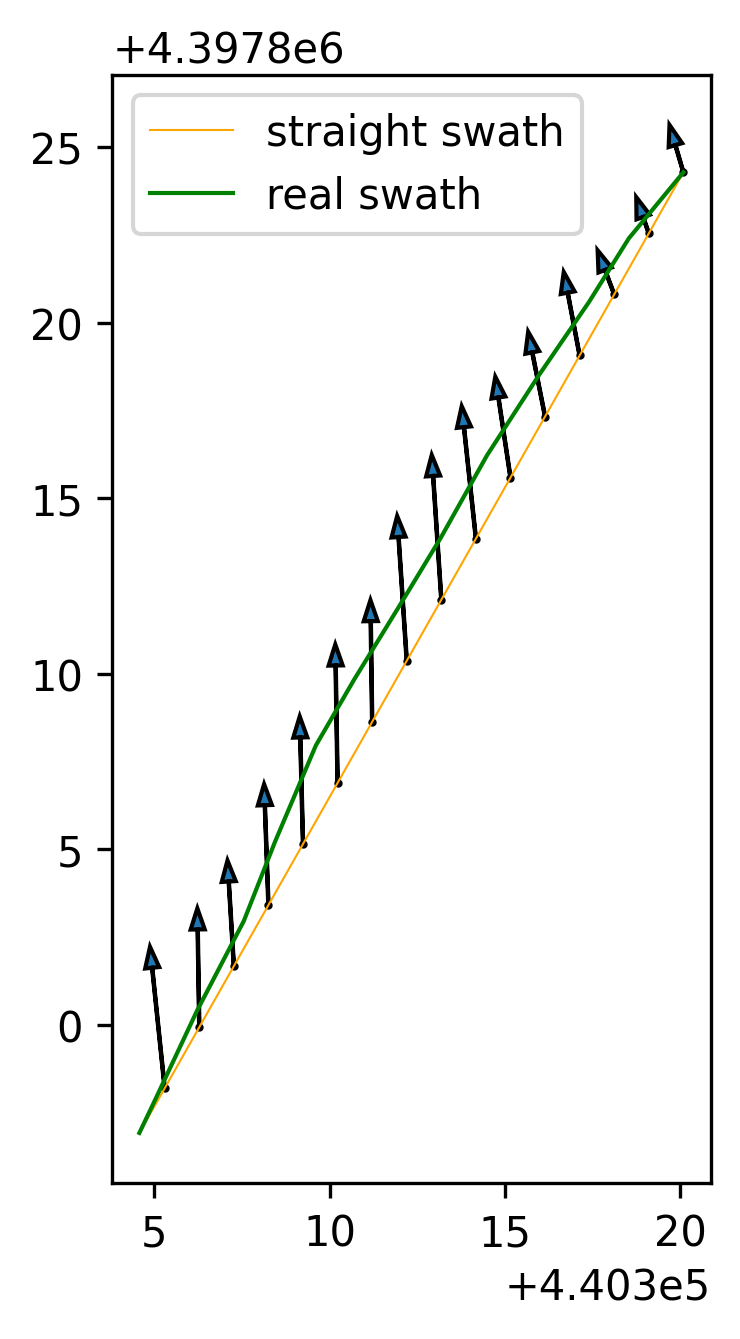

In [135]:
# lambdas = np.array([1, 1, 1, 1]) * 0.01

# plotting:
_, ax = plt.subplots(dpi=300)
ax.set_aspect('equal')
ax.plot(*sample_straight_land.xy, color='orange', linewidth=0.5)
ax.plot(*sample_real_land.xy, color='green', linewidth=1)
# plot dots and arrows
for sample_point in sample_points_data:
    ax.scatter(sample_point[0], sample_point[1], color='k', s=1)
    dx = lambdas[0] * np.cos(np.deg2rad(sample_point[3])) * np.deg2rad(sample_point[4]) * vehicle_weight + lambdas[2] * (sample_point[5] / vehicle_wheel_width)
    dy = lambdas[1] * np.sin(np.deg2rad(sample_point[3])) * np.deg2rad(sample_point[4]) * vehicle_weight + lambdas[3] * (sample_point[5] / vehicle_wheel_width)
    plt.arrow(sample_point[0], sample_point[1], dx, dy, width=0.01, head_width=0.4)
plt.legend(['straight swath', 'real swath'])

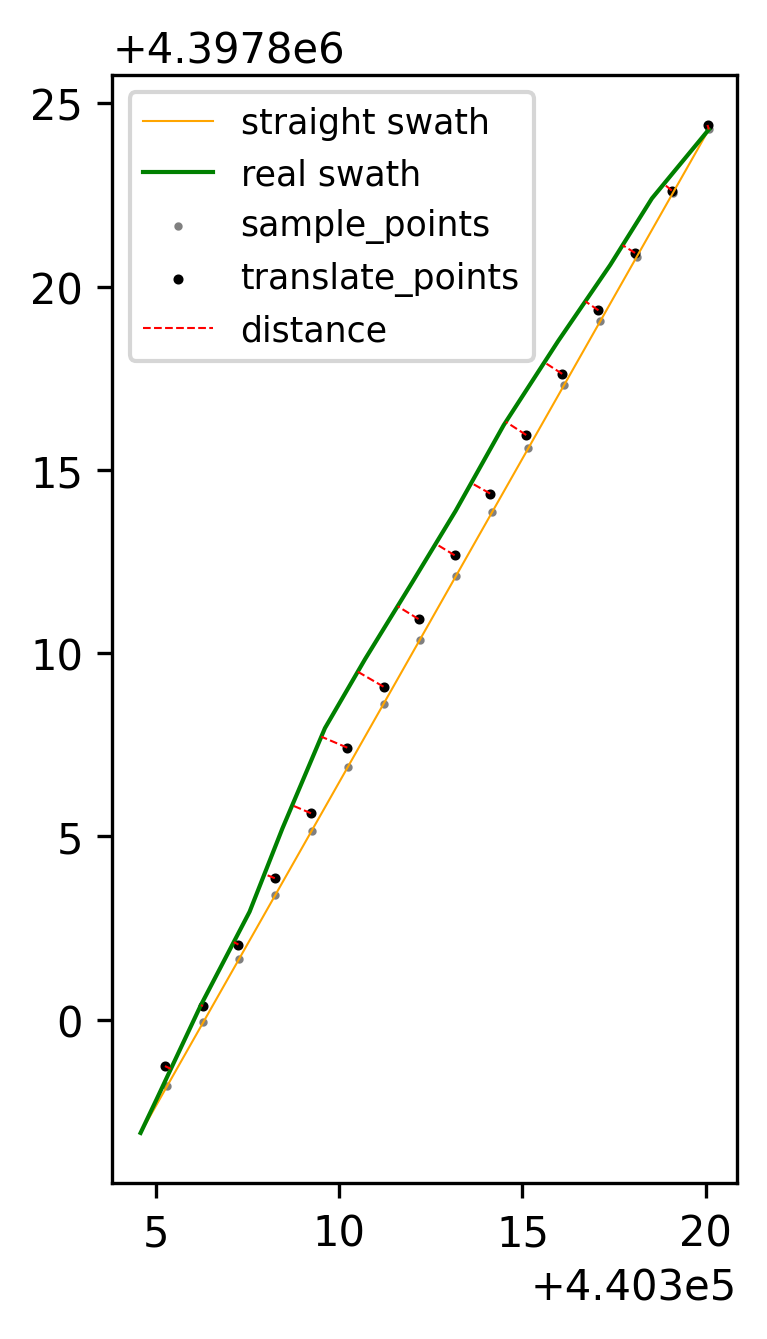

In [157]:
from shapely.ops import nearest_points
# 绘制优化过程
lambdas = optimal_params[1:] * 0.8
# plotting:
_, ax = plt.subplots(dpi=300)
ax.set_aspect('equal')
ax.plot(*sample_straight_land.xy, color='orange', linewidth=0.5)
ax.plot(*sample_real_land.xy, color='green', linewidth=1)
# plot dots and arrows
for sample_point in sample_points_data:
    ax.scatter(sample_point[0], sample_point[1], color='gray', s=1)
    dx = lambdas[0] * np.cos(np.deg2rad(sample_point[3])) * np.deg2rad(sample_point[4]) * vehicle_weight + lambdas[2] * (sample_point[5] / vehicle_wheel_width)
    dy = lambdas[1] * np.sin(np.deg2rad(sample_point[3])) * np.deg2rad(sample_point[4]) * vehicle_weight + lambdas[3] * (sample_point[5] / vehicle_wheel_width)
    ax.scatter(sample_point[0] + dx, sample_point[1] + dy, color='k', s=2)
    # find nearest_point
    temp_nearest_point = nearest_points(sample_real_land, Point(sample_point[0] + dx, sample_point[1] + dy))[0]
    temp_x, temp_y = [sample_point[0] + dx, temp_nearest_point.x], [sample_point[1] + dy, temp_nearest_point.y]
    ax.plot(temp_x, temp_y, linestyle='--', color='r', linewidth=0.5)
plt.legend(['straight swath', 'real swath', 'sample_points', 'translate_points', 'distance'], fontsize='small')

<AxesSubplot: >

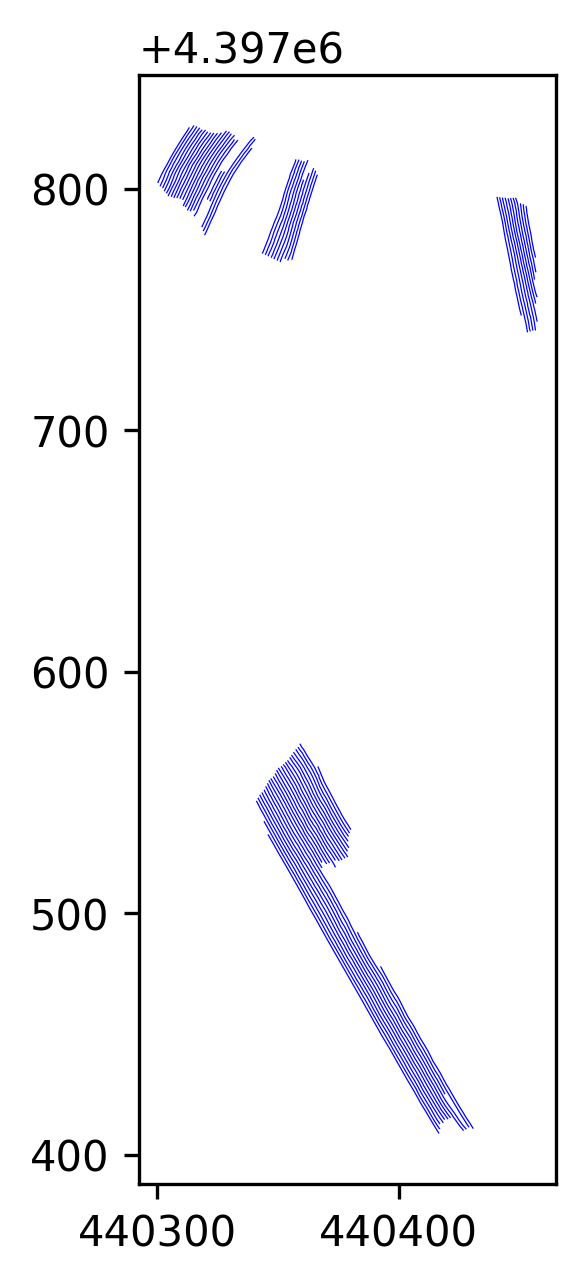

In [160]:
_, ax = plt.subplots(dpi=300)
real_swath.plot(ax=ax, color='b', linewidth=0.3)